<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Fit_TMS_fMRI_data_PerGroup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Fit_TMS_fMRI_data_PerGroup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fit TMS-fMRI Models Per Target Region Group

Train separate population models for each target region group.
Extends `Fit_TMS_fMRI_data.ipynb` workflow but applies it to subgroups of participants grouped by stimulation target.

In [1]:
# --- Setup cell ---

# 1️⃣ Mount Google Drive (for data)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2️⃣ Clone GitHub repository (for code)
import os, sys, subprocess, pickle, json, glob
from collections import defaultdict

repo_dir = "/content/BrainStim_ANN_fMRI_HCP"
if not os.path.exists(repo_dir):
    !git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git
else:
    print("Repo already exists ✅")

# 3️⃣ Define paths (TMS-fMRI)
data_dir = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
preproc_dir = os.path.join(data_dir, "preprocessed_subjects_tms_fmri")

# Where to save training outputs (per-group models)
weights_dir_group = os.path.join(preproc_dir, "trained_models_MLP_tms_fmri_pergroup")
os.makedirs(weights_dir_group, exist_ok=True)

# 4️⃣ Add repo to import path + imports
sys.path.append(repo_dir)

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from src import NPI
from src.preprocessing_tms_fmri import split_last_fraction, make_inputs_targets

import gc

# 5️⃣ Check device
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Running on:", torch.cuda.get_device_name(0))
else:
    print("⚠️  GPU not detected — training will run on CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive
Cloning into 'BrainStim_ANN_fMRI_HCP'...
remote: Enumerating objects: 562, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (201/201), done.
remote: Total 562 (delta 90), reused 10 (delta 10), pack-reused 351 (from 2)
Receiving objects: 100% (562/562), 70.62 MiB | 21.93 MiB/s, done.
Resolving deltas: 100% (198/198), done.
PyTorch version: 2.9.0+cu126
CUDA available: True
Running on: Tesla T4


In [2]:
# --- Load grouping summary from previous notebook ---

summary_pkl = os.path.join(data_dir, "TMS_fMRI", "target_regions_grouping_summary.pkl")
print(f"Loading grouping summary from: {summary_pkl}")

with open(summary_pkl, "rb") as f:
    grouping_summary = pickle.load(f)

subjects_list = grouping_summary['subjects_list']
multi_subject_groups = grouping_summary['multi_subject_groups']

print(f"✅ Loaded grouping summary")
print(f"Total subjects: {len(subjects_list)}")
print(f"Groups with ≥2 participants: {len(multi_subject_groups)}")
print(f"\nGroups to train:")
for target_id, info in sorted(multi_subject_groups.items()):
    print(f"  Target {target_id}: {info['subject_names']}")

Loading grouping summary from: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/TMS_fMRI/target_regions_grouping_summary.pkl
✅ Loaded grouping summary
Total subjects: 46
Groups with ≥2 participants: 11

Groups to train:
  Target 155: ['NTHC1009', 'NTHC1015', 'NTHC1016', 'NTHC1019', 'NTHC1021', 'NTHC1022', 'NTHC1024', 'NTHC1026', 'NTHC1027', 'NTHC1028', 'NTHC1029', 'NTHC1032', 'NTHC1035', 'NTHC1036', 'NTHC1037', 'NTHC1038', 'NTHC1039', 'NTHC1040', 'NTHC1043', 'NTHC1047', 'NTHC1049', 'NTHC1050', 'NTHC1052', 'NTHC1053', 'NTHC1055', 'NTHC1056', 'NTHC1057', 'NTHC1061', 'NTHC1062', 'NTHC1064', 'NTHC1066', 'NTHC1068', 'NTHC1073', 'NTHC1098', 'NTHC1099', 'NTHC1101', 'NTHC1102', 'NTHC1105', 'NTHC1107', 'NTHC1108']
  Target 220: ['NTHC1035', 'NTHC1036', 'NTHC1037', 'NTHC1038', 'NTHC1039', 'NTHC1040', 'NTHC1043', 'NTHC1047', 'NTHC1049', 'NTHC1050', 'NTHC1052', 'NTHC1053', 'NTHC1055', 'NTHC1056', 'NTHC1061', 'NTHC1062', 'NTHC1064', 'NTHC1065', 'NTHC1066', 'NTHC1068', 'NTHC1073', 'NTHC109

In [3]:
# --- Training parameters ---

# Choose ANN architecture: 'MLP', 'CNN', 'RNN', or 'VAR'
method = "MLP"

# Data / model hyperparameters
ROI_num = 450         # Tian 50 + Schaefer 400
using_steps = 3       # S: number of past steps used to predict next step

# Training hyperparameters
batch_size = 64
num_epochs = 50
learning_rate = 5e-4
l2_reg = 5e-5

# Population split rule (fixed): last 10% within each participant is test
test_fraction = 0.10

print(f"Training configuration:")
print(f"  Dataset: TMS-fMRI (task-rest only), per-group models")
print(f"  Method: {method}")
print(f"  Regions: {ROI_num}")
print(f"  Steps: {using_steps}")
print(f"  Test fraction (per-subject): {test_fraction}")
print(f"  Epochs: {num_epochs}")
print(f"  Batch size: {batch_size}")

Training configuration:
  Dataset: TMS-fMRI (task-rest only), per-group models
  Method: MLP
  Regions: 450
  Steps: 3
  Test fraction (per-subject): 0.1
  Epochs: 50
  Batch size: 64


### Notes on the split (important)

We **do not** concatenate raw time series across participants.

Instead:
1. For each participant in the group, we split the **filtered signals** into train/test by taking the **last 10%** as test.
2. We create **Inputs/Targets within each split**, so no sample ever crosses a subject boundary.
3. We then concatenate **samples** across participants in the group to form group-specific train and test sets.

In [4]:
# --- Define training function ---

def train_NN_fixed_test(
    model: nn.Module,
    X_train: np.ndarray,
    Y_train: np.ndarray,
    X_test: np.ndarray,
    Y_test: np.ndarray,
    batch_size: int = 64,
    num_epochs: int = 50,
    lr: float = 5e-4,
    l2: float = 0.0,
):
    """
    Train a model on (X_train,Y_train) and evaluate on (X_test,Y_test) each epoch.
    Mirrors NPI.train_NN style but avoids re-splitting internally.
    """
    model = model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    loss_fn = nn.MSELoss()

    train_inputs  = torch.tensor(X_train, dtype=torch.float32, device=device)
    train_targets = torch.tensor(Y_train, dtype=torch.float32, device=device)

    test_inputs  = torch.tensor(X_test, dtype=torch.float32, device=device) if X_test.size else None
    test_targets = torch.tensor(Y_test, dtype=torch.float32, device=device) if Y_test.size else None

    n_train = train_inputs.shape[0]
    train_epoch_loss, test_epoch_loss = [], []

    for ep in range(num_epochs):
        model.train()
        perm = torch.randperm(n_train, device=device)
        ep_loss = 0.0
        n_batches = 0

        for i in range(0, n_train, batch_size):
            idx = perm[i:i+batch_size]
            xb = train_inputs[idx]
            yb = train_targets[idx]

            pred = model(xb)
            loss = loss_fn(pred, yb)

            optim.zero_grad()
            loss.backward()
            optim.step()

            ep_loss += loss.item()
            n_batches += 1

        train_epoch_loss.append(ep_loss / max(1, n_batches))

        # test
        if test_inputs is not None and test_inputs.shape[0] > 0:
            model.eval()
            with torch.no_grad():
                pred = model(test_inputs)
                tloss = loss_fn(pred, test_targets).item()
            test_epoch_loss.append(tloss)
        else:
            test_epoch_loss.append(float("nan"))

        if (ep + 1) % 10 == 0 or ep == 0:
            print(f"Epoch {ep+1:3d}/{num_epochs} | train={train_epoch_loss[-1]:.6f} | test={test_epoch_loss[-1]:.6f}")

    return model, train_epoch_loss, test_epoch_loss

print("✅ Training function defined")

✅ Training function defined


In [5]:
# --- Train models for each group ---

group_results = {}

for target_id, group_info in sorted(multi_subject_groups.items()):
    print(f"\n{'='*70}")
    print(f"Training group: Target {target_id}")
    print(f"Participants: {group_info['subject_names']}")
    print(f"{'='*70}")

    subject_ids_in_group = group_info['subject_ids']
    subject_names_in_group = group_info['subject_names']

    # Build train/test datasets for this group
    X_train_list, Y_train_list = [], []
    X_test_list,  Y_test_list  = [], []

    for sid in subject_ids_in_group:
        subject_name = subjects_list[sid]
        subject_prefix = f"sub-{subject_name}"

        # Load signals for this subject
        sig_path = os.path.join(preproc_dir, f"{subject_prefix}_signals.npy")
        if not os.path.exists(sig_path):
            print(f"  ⚠️  {subject_prefix}_signals.npy not found, skipping")
            continue

        signals = np.load(sig_path)  # (T, 450)

        # Split last 10% test within subject
        sig_train, sig_test = split_last_fraction(signals, test_fraction=test_fraction)

        # Build Inputs/Targets within each split
        Xtr, Ytr = make_inputs_targets(sig_train, steps=using_steps)
        Xte, Yte = make_inputs_targets(sig_test,  steps=using_steps)

        # Accumulate
        if Xtr.shape[0] > 0:
            X_train_list.append(Xtr); Y_train_list.append(Ytr)
        if Xte.shape[0] > 0:
            X_test_list.append(Xte);  Y_test_list.append(Yte)

        print(f"  {subject_prefix} | signals: {signals.shape} | train: {Xtr.shape[0]} | test: {Xte.shape[0]}")

    # Concatenate samples across subjects in group
    X_train = np.concatenate(X_train_list, axis=0)
    Y_train = np.concatenate(Y_train_list, axis=0)
    X_test  = np.concatenate(X_test_list, axis=0) if len(X_test_list) else np.zeros((0, using_steps * ROI_num), dtype=np.float32)
    Y_test  = np.concatenate(Y_test_list, axis=0) if len(Y_test_list) else np.zeros((0, ROI_num), dtype=np.float32)

    print(f"\n  Group dataset shapes:")
    print(f"    X_train: {X_train.shape}, Y_train: {Y_train.shape}")
    print(f"    X_test:  {X_test.shape},  Y_test:  {Y_test.shape}")

    # Build and train model for this group
    print(f"\n  Training model...")
    model = NPI.build_model(method, ROI_num, using_steps)
    model, train_loss, test_loss = train_NN_fixed_test(
        model,
        X_train, Y_train,
        X_test, Y_test,
        batch_size=batch_size,
        num_epochs=num_epochs,
        lr=learning_rate,
        l2=l2_reg,
    )

    print(f"  ✅ Training complete | Final test loss: {test_loss[-1]:.6f}")

    # Save model
    model_path = os.path.join(weights_dir_group, f"target_{target_id:03d}_{method}_tms_fmri.pt")
    torch.save(model, model_path)

    # Save results
    results = {
        "target_id": int(target_id),
        "subject_ids": subject_ids_in_group,
        "subject_names": subject_names_in_group,
        "dataset": "TMS-fMRI task-rest (per-group)",
        "method": method,
        "ROI_num": ROI_num,
        "using_steps": using_steps,
        "batch_size": batch_size,
        "num_epochs": num_epochs,
        "learning_rate": learning_rate,
        "l2_reg": l2_reg,
        "test_fraction_per_subject": test_fraction,
        "n_subjects": len(subject_ids_in_group),
        "n_train_samples": int(X_train.shape[0]),
        "n_test_samples": int(X_test.shape[0]),
        "model_path": model_path,
        "train_loss": train_loss,
        "test_loss": test_loss,
    }

    results_path = os.path.join(weights_dir_group, f"results_target_{target_id:03d}_{method}_tms_fmri.json")
    with open(results_path, "w") as f:
        json.dump(results, f, indent=2)

    print(f"  💾 Saved model: {os.path.basename(model_path)}")
    print(f"  💾 Saved results: {os.path.basename(results_path)}")

    group_results[target_id] = results

    # Clean up
    del model, X_train, Y_train, X_test, Y_test
    gc.collect()

print(f"\n{'='*70}")
print(f"✅ Training complete for all {len(group_results)} groups")
print(f"{'='*70}")


Training group: Target 155
Participants: ['NTHC1009', 'NTHC1015', 'NTHC1016', 'NTHC1019', 'NTHC1021', 'NTHC1022', 'NTHC1024', 'NTHC1026', 'NTHC1027', 'NTHC1028', 'NTHC1029', 'NTHC1032', 'NTHC1035', 'NTHC1036', 'NTHC1037', 'NTHC1038', 'NTHC1039', 'NTHC1040', 'NTHC1043', 'NTHC1047', 'NTHC1049', 'NTHC1050', 'NTHC1052', 'NTHC1053', 'NTHC1055', 'NTHC1056', 'NTHC1057', 'NTHC1061', 'NTHC1062', 'NTHC1064', 'NTHC1066', 'NTHC1068', 'NTHC1073', 'NTHC1098', 'NTHC1099', 'NTHC1101', 'NTHC1102', 'NTHC1105', 'NTHC1107', 'NTHC1108']
  sub-NTHC1009 | signals: (210, 450) | train: 186 | test: 18
  sub-NTHC1015 | signals: (420, 450) | train: 375 | test: 39
  sub-NTHC1016 | signals: (210, 450) | train: 186 | test: 18
  sub-NTHC1019 | signals: (420, 450) | train: 375 | test: 39
  sub-NTHC1021 | signals: (210, 450) | train: 186 | test: 18
  sub-NTHC1022 | signals: (210, 450) | train: 186 | test: 18
  sub-NTHC1024 | signals: (210, 450) | train: 186 | test: 18
  sub-NTHC1026 | signals: (210, 450) | train: 186 

In [6]:
# --- Summary of all groups ---

print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)

for target_id in sorted(group_results.keys()):
    res = group_results[target_id]
    print(f"\nTarget {target_id} ({', '.join(res['subject_names'])})")
    print(f"  Subjects: {res['n_subjects']}")
    print(f"  Samples: {res['n_train_samples']} train, {res['n_test_samples']} test")
    print(f"  Final test loss: {res['test_loss'][-1]:.6f}")
    print(f"  Model saved: {os.path.basename(res['model_path'])}")


TRAINING SUMMARY

Target 155 (NTHC1009, NTHC1015, NTHC1016, NTHC1019, NTHC1021, NTHC1022, NTHC1024, NTHC1026, NTHC1027, NTHC1028, NTHC1029, NTHC1032, NTHC1035, NTHC1036, NTHC1037, NTHC1038, NTHC1039, NTHC1040, NTHC1043, NTHC1047, NTHC1049, NTHC1050, NTHC1052, NTHC1053, NTHC1055, NTHC1056, NTHC1057, NTHC1061, NTHC1062, NTHC1064, NTHC1066, NTHC1068, NTHC1073, NTHC1098, NTHC1099, NTHC1101, NTHC1102, NTHC1105, NTHC1107, NTHC1108)
  Subjects: 40
  Samples: 7818 train, 762 test
  Final test loss: 0.314419
  Model saved: target_155_MLP_tms_fmri.pt

Target 220 (NTHC1035, NTHC1036, NTHC1037, NTHC1038, NTHC1039, NTHC1040, NTHC1043, NTHC1047, NTHC1049, NTHC1050, NTHC1052, NTHC1053, NTHC1055, NTHC1056, NTHC1061, NTHC1062, NTHC1064, NTHC1065, NTHC1066, NTHC1068, NTHC1073, NTHC1098, NTHC1101, NTHC1102, NTHC1105, NTHC1107, NTHC1108)
  Subjects: 27
  Samples: 5022 train, 486 test
  Final test loss: 0.423876
  Model saved: target_220_MLP_tms_fmri.pt

Target 231 (NTHC1009, NTHC1015, NTHC1016, NTHC1019,

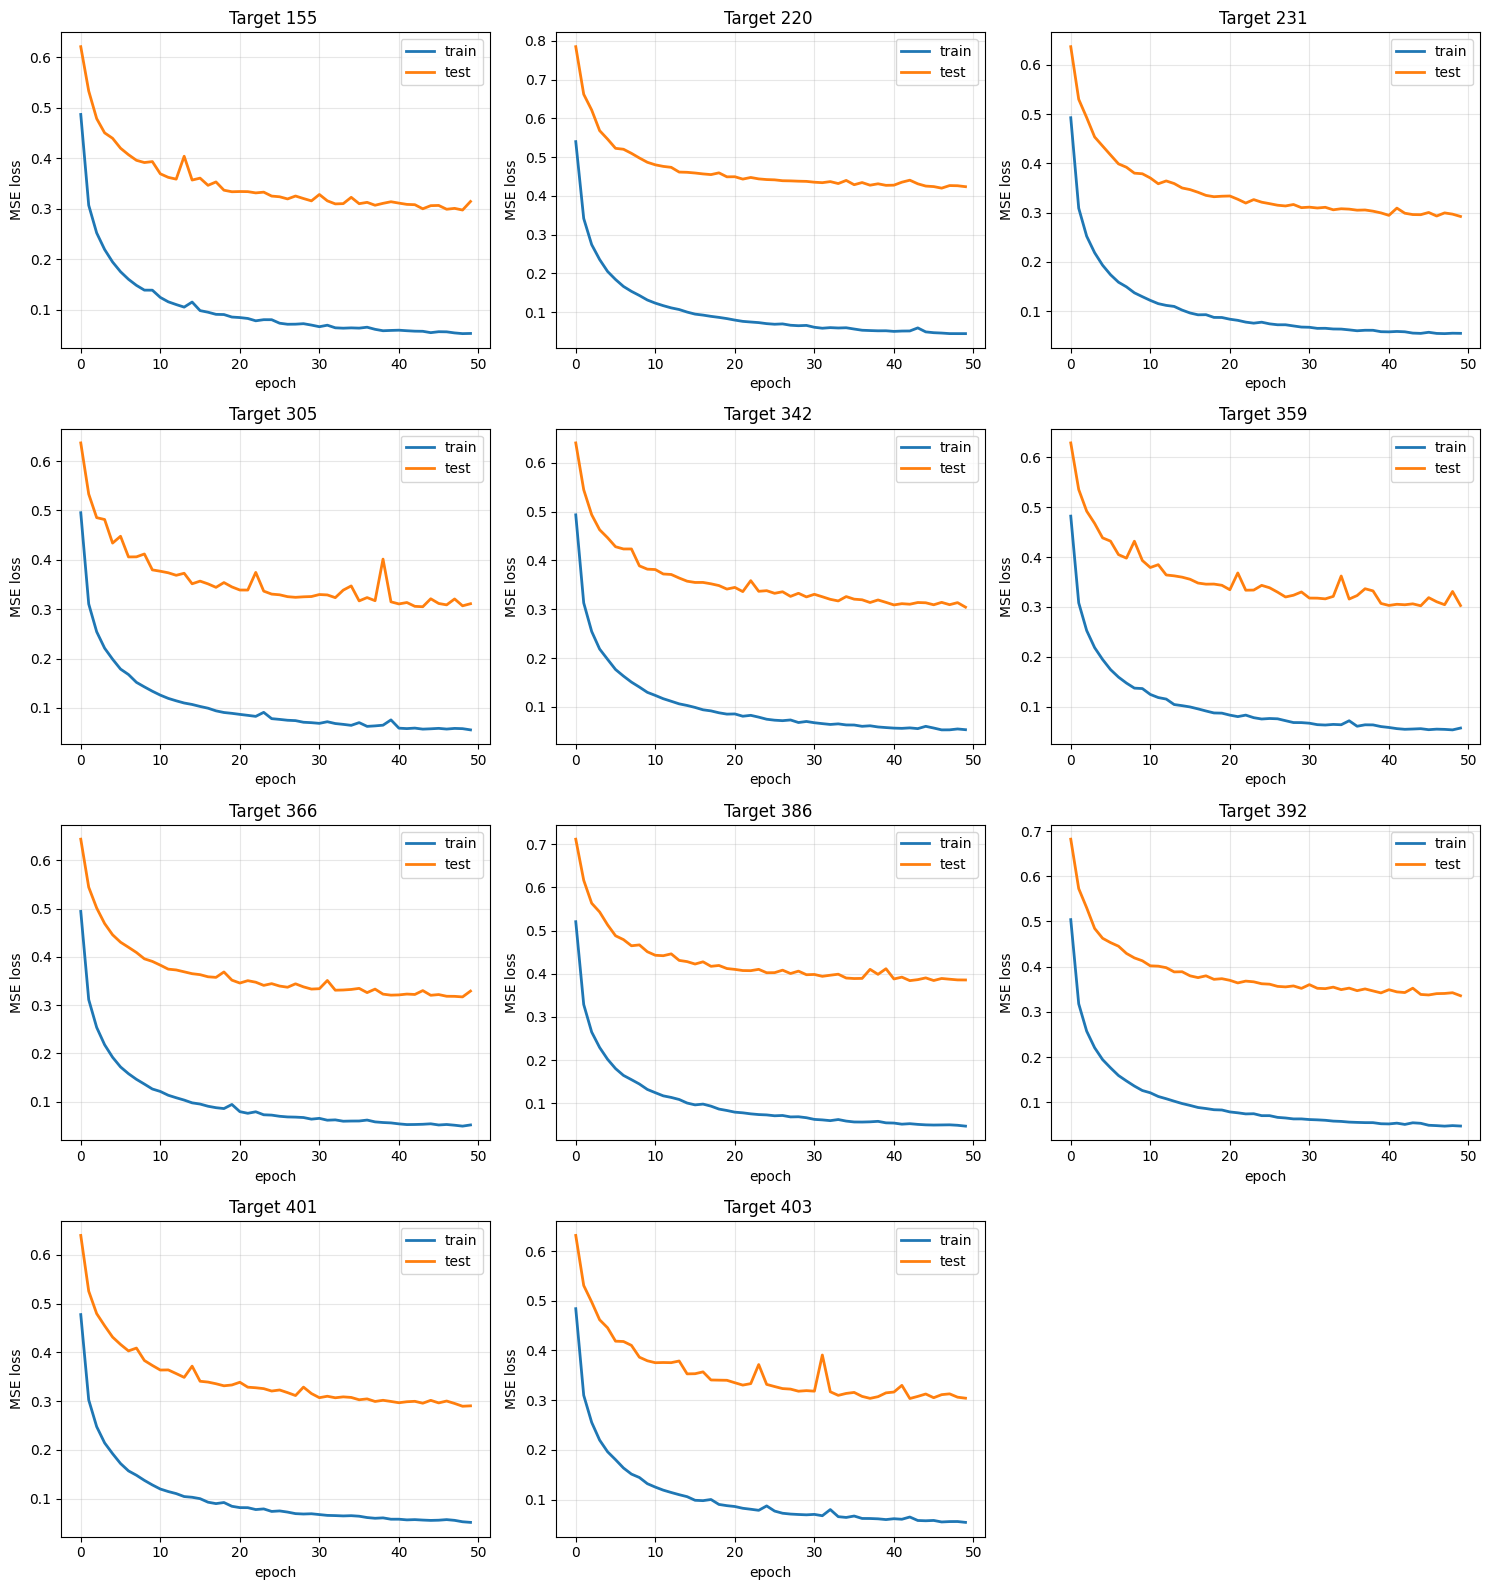

✅ Learning curves plotted


In [8]:
# --- Visualize learning curves for all groups ---

n_groups = len(group_results)
ncols = min(3, n_groups)
nrows = (n_groups + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
if n_groups == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, target_id in enumerate(sorted(group_results.keys())):
    res = group_results[target_id]
    ax = axes[idx]

    ax.plot(res['train_loss'], label='train', linewidth=2)
    ax.plot(res['test_loss'], label='test', linewidth=2)
    ax.set_xlabel('epoch')
    ax.set_ylabel('MSE loss')
    ax.set_title(f"Target {target_id} ")#| {', '.join(res['subject_names'])}")
    ax.legend()
    ax.grid(alpha=0.3)

# Hide unused subplots
for idx in range(n_groups, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

print("✅ Learning curves plotted")

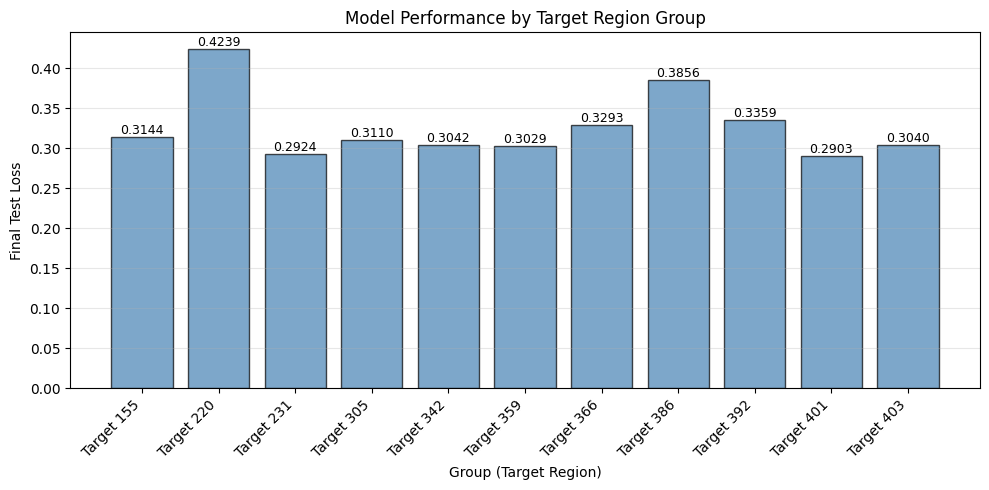

✅ Performance comparison plotted


In [10]:
# --- Visualize final test loss comparison across groups ---

target_ids = sorted(group_results.keys())
final_test_losses = [group_results[tid]['test_loss'][-1] for tid in target_ids]
group_labels = [f"Target {tid}" for tid in target_ids] #\n{', '.join(group_results[tid]['subject_names'])}

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(range(len(target_ids)), final_test_losses, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_xlabel('Group (Target Region)')
ax.set_ylabel('Final Test Loss')
ax.set_title('Model Performance by Target Region Group')
ax.set_xticks(range(len(target_ids)))
ax.set_xticklabels(group_labels, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, loss in zip(bars, final_test_losses):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{loss:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("✅ Performance comparison plotted")

In [11]:
# --- Save master summary of all group training results ---

master_summary = {
    'method': method,
    'ROI_num': ROI_num,
    'using_steps': using_steps,
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'l2_reg': l2_reg,
    'test_fraction': test_fraction,
    'n_groups': len(group_results),
    'group_results': group_results,
}

master_summary_path = os.path.join(weights_dir_group, "master_summary_all_groups.pkl")
with open(master_summary_path, "wb") as f:
    pickle.dump(master_summary, f)

print(f"💾 Saved master summary to: {master_summary_path}")
print(f"\n✅ All training complete!")

💾 Saved master summary to: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/trained_models_MLP_tms_fmri_pergroup/master_summary_all_groups.pkl

✅ All training complete!
